In [4]:
%load_ext autoreload
%autoreload 2

In [144]:
from gpt3forchem.data import get_photoswitch_data
from gpt3forchem.input import generate_inverse_photoswitch_prompts
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_prediction, extract_inverse_prediction
import time
from sklearn.model_selection import train_test_split
from gpt3forchem.output import FrechetBenchmark, KLDivBenchmark, test_inverse_photoswitch
import seaborn as sns

In [181]:
data = get_photoswitch_data()
data = data.dropna(subset=['E isomer pi-pi* wavelength in nm', 'E isomer n-pi* wavelength in nm'])

In [182]:
data

,index,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,Z isomer pi-pi* wavelength in nm,Extinction.1,Z isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1.1,Wiberg index,E-Z irradiation wavelength in nm,Z-E irradiation wavelength,Irradiation solvent,PBE0 DFT E isomer pi-pi* wavelength in nm,PBE0 DFT E isomer n-pi* wavelength in nm,PBE0 DFT Z isomer pi-pi* wavelength in nm,PBE0 DFT Z isomer n-pi* wavelength in nm,TPSSh/6-31G** DFT E isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT E isomer n-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm,name,selfies,wavelength_cat,inchi
0,0,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.0,1.67,442.0,0.0373,290.0,0.243,428.0,0.1010,1.896,355,532,MeCN,305.0,480.0,286.0,448.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][N][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C10H10N4/c1-14-8-7-10(13-14)12-11-9-5...
1,1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.0,1.87,438.0,0.0505,272.0,0.489,434.0,0.1270,1.899,355,532,MeCN,306.0,473.0,284.0,448.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C9H9N5/c1-14-7-10-9(13-14)12-11-8-5-3...
2,3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.0,1.74,428.0,0.0612,286.0,0.515,438.0,0.1360,1.874,355,532,MeCN,317.0,458.0,302.0,461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][C][C][C][=Branch1][Ri...,very small,InChI=1S/C11H12N4/c1-9-8-15(2)14-11(9)13-12-10...
3,4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.0,1.66,417.0,0.0640,275.0,0.806,403.0,0.0666,1.849,355,532,MeCN,318.0,447.0,278.0,409.0,328.0,455.0,295.0,410.0,305.0,427.0,256.0,401.0,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][Branch1][C][=N][Ring1...,very small,InChI=1S/C10H10N4/c1-14-8-10(7-11-14)13-12-9-5...
4,5,C[N]1N=C(C)C(=C1C)N=NC2=CC=CC=C2,7.700000e-07,MeCN,98.0,98.0,335.0,2.27,425.0,0.0963,296.0,0.577,441.0,0.2300,1.837,355,532,MeCN,327.0,443.0,297.0,460.0,337.0,453.0,311.0,462.0,314.0,422.0,279.0,449.0,NaN,NaN,NaN,NaN,"phenyl-(1,3,5-trimethylpyrazol-4-yl)diazene",[C][NH0][N][=C][Branch1][C][C][C][=Branch1][Br...,very small,InChI=1S/C12H14N4/c1-9-12(10(2)16(3)15-9)14-13...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,162,CC1=CC(/N=N/C2=CC(C)=C(C)C=C2)=CC=C1C,NaN,NaN,NaN,NaN,333.0,NaN,441.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CH,356.0,473.0,NaN,NaN,NaN,NaN,NaN,NaN,343.0,445.0,NaN,NaN,NaN,NaN,NaN,NaN,"BIS(3,4-DIMETHYLPHENYL)DIAZENE",[C][C][=C][C][Branch1][P][/N][=N][/C][=C][C][B...,very small,InChI=1S/C16H18N2/c1-11-5-7-15(9-13(11)3)17-18...
149,163,CC1=C(Cl)C=CC=C1/N=N/C2=C(C)C(Cl)=CC=C2,NaN,NaN,NaN,NaN,329.0,NaN,461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CH,341.0,495.0,NaN,NaN,NaN,NaN,NaN,NaN,325.0,471.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[C][C][=C][Branch1][C][Cl][C][=C][C][=C][Ring1...,very small,InChI=1S/C14H12Cl2N2/c1-9-11(15)5-3-7-13(9)17-...
150,164,CC1=CC(Cl)=CC=C1/N=N/C2=C(C)C=C(Cl)C=C2,NaN,NaN,NaN,NaN,346.0,NaN,461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CH,379.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,360.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN,Bis(4-chloro-2-methylphenyl)diazene,[C][C][=C][C][Branch1][C][Cl][=C][C][=C][Ring

In [184]:
train_df, test_df = train_test_split(data, train_size=100, random_state=None, stratify=data["wavelength_cat"])

In [185]:
train_prompts_smiles = generate_inverse_photoswitch_prompts(train_df, 'SMILES')
test_prompts_smiles = generate_inverse_photoswitch_prompts(test_df, 'SMILES')

train_prompts_selfies = generate_inverse_photoswitch_prompts(train_df, 'selfies')
test_prompts_seflies = generate_inverse_photoswitch_prompts(test_df, 'selfies')

In [186]:
train_smiles = train_prompts_smiles['completion'].apply(lambda x: x.split('@@@')[0])
test_smiles = test_prompts_smiles['completion'].apply(lambda x: x.split('@@@')[0])
train_prompts_smiles['SMILES'] = train_smiles
test_prompts_smiles['SMILES'] = test_smiles


train_smiles = train_prompts_selfies['completion'].apply(lambda x: x.split('@@@')[0])
test_smiles = test_prompts_seflies['completion'].apply(lambda x: x.split('@@@')[0])
train_prompts_selfies['SMILES'] = train_smiles
test_prompts_seflies['SMILES'] = test_smiles

In [188]:
def train_inverse_model(df_train, representation):
    train_prompts = generate_inverse_photoswitch_prompts(
        df_train,
        representation=representation,
    )

    train_size = len(train_prompts)

    filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
    train_filename = f"run_files/{filename_base}_train_prompts_photoswitch_inverse_{representation}_{train_size}.jsonl"

    train_prompts.to_json(train_filename, orient="records", lines=True)

    modelname = fine_tune(train_filename, train_filename, "ada")
    return modelname, train_filename

In [189]:
def test_inverse_model(modelname, test_prompts, df_train, max_tokens: int =100, temperatures=None, representation="SMILES"): 
    temperatures = temperatures or  [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

    train_repr = df_train['completion'].apply(lambda x: x.split('@@@')[0])
    train_smiles = df_train['SMILES'].to_list()
    results = []
    for temperature in temperatures:
        try:
            print(f"Testing temperature {temperature}")
            result = test_inverse_photoswitch(
                test_prompts, modelname, train_smiles=train_smiles, temperature=temperature, max_tokens=max_tokens, representation=representation
            )

            results.append(result)
        except Exception as e:
            print(e)
            pass
    
    return results

In [190]:
model_smiles, train_filename_smiles = train_inverse_model(train_df, 'SMILES')

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [191]:
results_smiles = test_inverse_model(model_smiles, test_prompts, train_prompts, representation='SMILES')

Testing temperature 0


2022-11-24 10:08:06.884 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.25


2022-11-24 10:08:45.935 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.5


2022-11-24 10:09:25.510 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.75


2022-11-24 10:10:01.807 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.0


2022-11-24 10:10:36.902 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.25


2022-11-24 10:11:05.577 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.5


2022-11-24 10:11:29.343 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


In [192]:
model_selfies, train_filename = train_inverse_model(train_df, 'selfies')

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [193]:
results_selfies = test_inverse_model(model_selfies, test_prompts, train_prompts, representation='selfies')

Testing temperature 0


2022-11-24 10:22:20.387 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.25


2022-11-24 10:22:37.980 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.5


2022-11-24 10:22:55.247 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.75


2022-11-24 10:23:12.251 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.0


2022-11-24 10:23:29.092 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.25


2022-11-24 10:23:44.610 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Testing temperature 1.5


2022-11-24 10:23:57.995 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(
/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/gpt3forchem/output.py:238: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(gen_mol_act.T)
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)

In [196]:
summarized_metrics_smiles = []

for metric in results_smiles:
    res = {
        'temperature': metric['meta']['temperature'],
         'fractions_valid_smiles': metric['fractions_valid_smiles'],
        'fractions_smiles_in_train': metric['fractions_smiles_in_train'],
        'unique_smiles': metric['unique_smiles'],
        'frechet_chemnet': metric['frechet_chemnet'][0],
        'pi_pi_star_mae': metric['pi_pi_star_metrics']['mean_absolute_error'],
        'n_pi_star_mae': metric['n_pi_star_metrics']['mean_absolute_error'],
    }
    summarized_metrics_smiles.append(res)

In [214]:
summarized_metrics_selfies = []

for metric in results_selfies:
    try:
        res = {
            'temperature': metric['meta']['temperature'],
            'fractions_valid_smiles': metric['fractions_valid_smiles'],
            'fractions_smiles_in_train': metric['fractions_smiles_in_train'],
            'unique_smiles': metric['unique_smiles'],
            'frechet_chemnet': metric['frechet_chemnet'][0],
            'pi_pi_star_mae': metric['pi_pi_star_metrics']['mean_absolute_error'],
            'n_pi_star_mae': metric['n_pi_star_metrics']['mean_absolute_error'],
        }
        summarized_metrics_selfies.append(res)
    except Exception as e:
        print(e)
        pass

'float' object is not subscriptable


In [215]:
import pandas as pd 

In [216]:
summarized_metrics_smiles = pd.DataFrame(summarized_metrics_smiles)

In [217]:
summarized_metrics_selfies = pd.DataFrame(summarized_metrics_selfies)

In [218]:
summarized_metrics_smiles

,temperature,fractions_valid_smiles,fractions_smiles_in_train,unique_smiles,frechet_chemnet,pi_pi_star_mae,n_pi_star_mae
0,0.00,1.000000,1.000000,0.037037,36.072354,10.100238,18.692186
1,0.25,1.000000,0.962963,0.407407,18.545717,11.081418,15.765166
2,0.50,1.000000,0.703704,0.851852,11.965924,13.913277,16.102152
3,0.75,0.962963,0.500000,0.769231,12.731376,18.740009,13.973313
4,1.00,0.703704,0.263158,0.947368,12.555560,19.781969,19.829297
5,1.25,0.407407,0.363636,1.000000,16.034878,20.291984,19.615695
6,1.50,0.148148,0.250000,1.000000,43.141452,47.273484,12.570229


In [219]:
summarized_metrics_selfies

,temperature,fractions_valid_smiles,fractions_smiles_in_train,unique_smiles,frechet_chemnet,pi_pi_star_mae,n_pi_star_mae
0,0.00,1.0,1.0,0.1,30.763860,14.860644,15.847897
1,0.25,1.0,1.0,0.6,21.133284,17.145121,16.161213
2,0.50,1.0,0.6,0.8,21.971883,18.847654,12.026004
3,0.75,1.0,0.2,1.0,22.468951,18.138859,21.904086
4,1.00,0.8,0.5,1.0,26.385752,25.384072,18.848716
5,1.25,0.5,0.0,1.0,38.639223,27.858076,22.588903


In [220]:
print(summarized_metrics_selfies.style.format({c: "{:.2f}" for c in summarized_metrics_selfies.columns if c != 'temperature'}).hide_index().to_latex())

\begin{tabular}{rrrrrrr}
temperature & fractions_valid_smiles & fractions_smiles_in_train & unique_smiles & frechet_chemnet & pi_pi_star_mae & n_pi_star_mae \\
0.000000 & 1.00 & 1.00 & 0.10 & 30.76 & 14.86 & 15.85 \\
0.250000 & 1.00 & 1.00 & 0.60 & 21.13 & 17.15 & 16.16 \\
0.500000 & 1.00 & 0.60 & 0.80 & 21.97 & 18.85 & 12.03 \\
0.750000 & 1.00 & 0.20 & 1.00 & 22.47 & 18.14 & 21.90 \\
1.000000 & 0.80 & 0.50 & 1.00 & 26.39 & 25.38 & 18.85 \\
1.250000 & 0.50 & 0.00 & 1.00 & 38.64 & 27.86 & 22.59 \\
\end{tabular}



/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_96029/2013303749.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  print(summarized_metrics_selfies.style.format({c: "{:.2f}" for c in summarized_metrics_selfies.columns if c != 'temperature'}).hide_index().to_latex())


In [221]:
print(summarized_metrics_smiles.style.format({c: "{:.2f}" for c in summarized_metrics_smiles.columns if c != 'temperature'}).hide_index().to_latex())

\begin{tabular}{rrrrrrr}
temperature & fractions_valid_smiles & fractions_smiles_in_train & unique_smiles & frechet_chemnet & pi_pi_star_mae & n_pi_star_mae \\
0.000000 & 1.00 & 1.00 & 0.04 & 36.07 & 10.10 & 18.69 \\
0.250000 & 1.00 & 0.96 & 0.41 & 18.55 & 11.08 & 15.77 \\
0.500000 & 1.00 & 0.70 & 0.85 & 11.97 & 13.91 & 16.10 \\
0.750000 & 0.96 & 0.50 & 0.77 & 12.73 & 18.74 & 13.97 \\
1.000000 & 0.70 & 0.26 & 0.95 & 12.56 & 19.78 & 19.83 \\
1.250000 & 0.41 & 0.36 & 1.00 & 16.03 & 20.29 & 19.62 \\
1.500000 & 0.15 & 0.25 & 1.00 & 43.14 & 47.27 & 12.57 \\
\end{tabular}



/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_96029/3754352092.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  print(summarized_metrics_smiles.style.format({c: "{:.2f}" for c in summarized_metrics_smiles.columns if c != 'temperature'}).hide_index().to_latex())


In [ ]:
len(train_prompts)

300

## Now, let's try to exclude a part

In [ ]:
data_subset = data.dropna(subset=['E isomer pi-pi* wavelength in nm', 'E isomer n-pi* wavelength in nm'])

/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


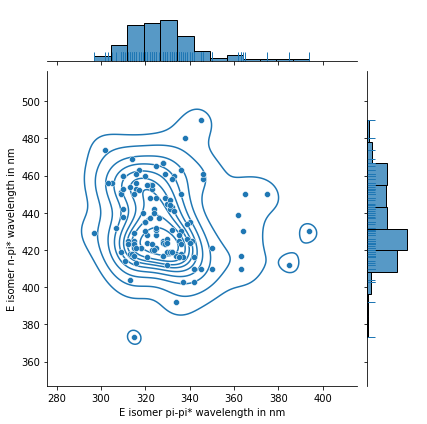

In [ ]:
g = sns.jointplot('E isomer pi-pi* wavelength in nm', 'E isomer n-pi* wavelength in nm', data=data_subset)
g.plot_joint(sns.kdeplot, zorder=0, levels=10)
g.plot_marginals(sns.rugplot, height=.15, clip_on=False)

<AxesSubplot:>

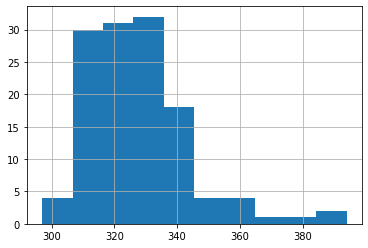

In [222]:
data_subset['E isomer pi-pi* wavelength in nm'].hist()

<AxesSubplot:>

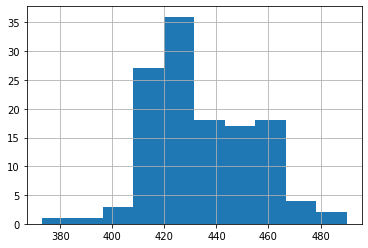

In [223]:
data_subset['E isomer n-pi* wavelength in nm'].hist()

In [234]:
train_mask_hard = (data['E isomer pi-pi* wavelength in nm']   < 338) & (data['E isomer n-pi* wavelength in nm'] > 405) # tuned a bit to again get 100 train examples
train_data_hard = data[train_mask_hard]
test_data_hard = data[~train_mask_hard]

In [233]:
len(train_data_hard)

100

In [ ]:
train_smiles_hard = train_prompts_hard['completion'].apply(lambda x: x.split('@@@')[0])
test_smiles_hard = test_prompts_hard['completion'].apply(lambda x: x.split('@@@')[0])
train_prompts_hard['SMILES'] = train_smiles_hard
test_prompts_hard['SMILES'] = test_smiles_hard

In [235]:
model_smiles_hard, train_filename_smiles_hard = train_inverse_model(train_data_hard, 'SMILES')

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [ ]:
train_prompts = generate_inverse_photoswitch_prompts(train_df, 'SMILES')
test_prompts = generate_inverse_photoswitch_prompts(test_df, 'SMILES')

In [ ]:
results_smiles_hard = test_inverse_model(model_smiles_hard, test_prompts_hard, train_prompts, representation='SMILES')